<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/book1/intro/sklearn_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to sklearn

[Scikit-learn](http://scikit-learn.org) is a widely used Python machine learning library. There are several good tutorials on it, some of which we list below. 


| Name | Notes |
| ---- | ---- | 
|[Python data science handbook](https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.02-Introducing-Scikit-Learn.ipynb)|  by Jake VanderPlas. Covers many python libraries. |
|[Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow v2](https://github.com/ageron/handson-ml2)| by Aurelion Geron. Covers sklearn and TF2.|
|[Python Machine Learning v3](https://sebastianraschka.com/books.html) | by Sebastian Raschka. Covers sklearn and TF2. |

In the sections below, we just give a few examples of how to use it.


If you want to scale up sklearn to handle datasets that do not fit into memory, and/or you want to run slow jobs in parallel (e.g., for grid search over model hyper-parameters) on multiple cores of your laptop or in the cloud, you should use [ML-dask](https://ml.dask.org/).

# Install necessary libraries




In [ ]:
# Standard Python libraries
from __future__ import absolute_import, division, print_function, unicode_literals

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio

from IPython import display

import sklearn

import seaborn as sns;
sns.set(style="ticks", color_codes=True)

import pandas as pd
pd.set_option('precision', 2) # 2 decimal places
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 100) # wide windows



# Estimators

Most of sklearn is designed around the concept of "estimators", which are objects that can transform data. That is, we can think of an estimator as a function of the form $f(x,\theta)$, where $x$ is the input, and $\theta$ is the internal state (e.g., model parameters) of the object. Each estimator has two main methods:  ```fit``` and ```predict```. The fit method has the form ```f=fit(f,data)```, and updates the internal state (e.g., by computing the maximum likelihood estimate of the parameters). The predict method has the form ```y=predict(f,x)```. We can also have stateless estimators (with no internal parameters), which do things like preprocess the data. We give examples of all this below.

# Logistic regression 

We illustrate how to fit a logistic regression model using the Iris dataset.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets

iris = datasets.load_iris()

# use 2 features and all 3 classes
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]

#softmax_reg = LogisticRegression(multi_class="multinomial", solver="lbfgs", penalty="none")
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=1000, random_state=42)
softmax_reg.fit(X, y)

# Get predictive distribution for a single example
X = [[2.5, 3.0]] # (1,2) array
y_probs = softmax_reg.predict_proba(X)
print(np.round(y_probs, 2))

[[0.01 0.4  0.6 ]]


In [ ]:
# Fit model and evaluate on separate test set

from sklearn.model_selection import train_test_split
iris = datasets.load_iris()
X = iris.data[:, :2]  # we only take the first two features to make problem harder
#X = iris.data # use all data
y = iris.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# compute MLE (penalty=None means do not use regularization)
logreg = LogisticRegression(solver='lbfgs', multi_class='multinomial', penalty='none')
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test) # categorical labels
errs = (y_pred != y_test)
nerrs = np.sum(errs)
print("Made {} errors out of {}, on instances {}".format(nerrs, len(y_pred), np.where(errs)))
# With ndims=2: Made 10 errors out of 50, on instances
#  (array([ 4, 15, 21, 32, 35, 36, 40, 41, 42, 48]),)


from sklearn.metrics import zero_one_loss
err_rate_test = zero_one_loss(y_test, y_pred)
assert np.isclose(err_rate_test, nerrs / len(y_pred))
err_rate_train =  zero_one_loss(y_train, logreg.predict(X_train))
print("Error rates on train {:0.3f} and test {:0.3f}".format(
    err_rate_train, err_rate_test))
#Error rates on train 0.180 and test 0.200

Made 10 errors out of 50, on instances (array([ 4, 15, 21, 32, 35, 36, 40, 41, 42, 48]),)
Error rates on train 0.180 and test 0.200


# Data preprocessing <a class="anchor" id="preprocess"></a>

We often have to preprocess data before feeding it to an ML model. 
We give some examples below.

### Standardizing numeric features in Boston housing <a class="anchor" id="preprocess-boston"></a>

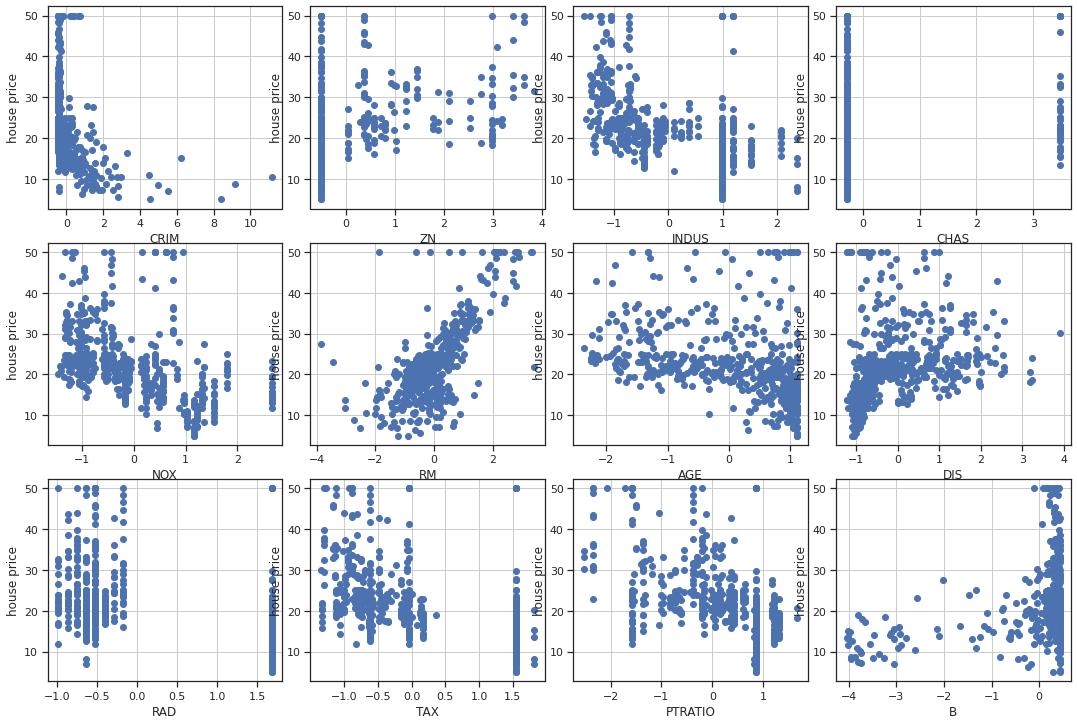

In [ ]:
import sklearn.datasets
import sklearn.linear_model as lm
from sklearn.model_selection import train_test_split


boston = sklearn.datasets.load_boston()
X = boston.data
y = boston.target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

scaler = sklearn.preprocessing.StandardScaler()
scaler = scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_scaled = scaler.transform(X) # entire dataset

# scatter plot of response vs each feature.
# The shape of the data looks the same as the unscaled case, but the x-axis of each feature is changed.
nrows = 3; ncols = 4;
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharey=True, figsize=[15,10])
plt.tight_layout()
plt.clf()
for i in range(0,12):
    plt.subplot(nrows, ncols, i+1)
    plt.scatter(X_scaled[:,i], y)
    plt.xlabel(boston.feature_names[i])
    plt.ylabel("house price")
    plt.grid()
#save_fig("boston-housing-scatter-scaled.pdf")
plt.show()

### One-hot encoding for Autompg <a class="anchor" id="preprocess-onehot"></a>

We need to convert categorical inputs (aka factors) to one-hot vectors. We illustrate this below.


In [ ]:
# Get data 
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Year', 'Origin', 'Name']
df = pd.read_csv(url, names=column_names, sep='\s+', na_values="?")

# The last column (name) is a unique id for the car, so we drop it
df = df.drop(columns=['Name'])

# Ensure same number of rows for all features.
df = df.dropna()

# Convert origin integer to categorical factor
df['Origin'] = df.Origin.replace([1,2,3],['USA','Europe','Japan'])
df['Origin'] = df['Origin'].astype('category')


df.info()

df.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   MPG           392 non-null    float64 
 1   Cylinders     392 non-null    int64   
 2   Displacement  392 non-null    float64 
 3   Horsepower    392 non-null    float64 
 4   Weight        392 non-null    float64 
 5   Acceleration  392 non-null    float64 
 6   Year          392 non-null    int64   
 7   Origin        392 non-null    category
dtypes: category(1), float64(5), int64(2)
memory usage: 25.0 KB


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [ ]:
# Convert origin factor to integer
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
origin_cat = df['Origin']

print('before transform')
print(origin_cat)

origin_int = encoder.fit_transform(origin_cat)
print('after transform')
print(origin_int)

# Make sure we can decode back to strings
print('class names are {}'.format(encoder.classes_))
origin_cat2 = encoder.inverse_transform(origin_int)
print(origin_cat2)

before transform
0         USA
1         USA
2         USA
3         USA
4         USA
        ...  
393       USA
394    Europe
395       USA
396       USA
397       USA
Name: Origin, Length: 392, dtype: category
Categories (3, object): ['Europe', 'Japan', 'USA']
after transform
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 0 0 0 0 0 2 2 2 2 2 1 2 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 1 1 0 2 1 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2
 2 0 0 0 0 2 1 1 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 2 2 2 2 1 2 1 1
 2 2 0 2 2 0 0 0 0 2 0 1 2 2 2 2 1 2 1 2 2 2 2 2 2 2 2 2 0 0 0 1 1 2 0 0 1
 1 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 1 0 1 2 0 2 0 0 0 0 1 0 0 2 2 0
 2 2 2 2 2 2 2 2 2 2 0 1 2 2 2 2 0 1 1 2 0 2 0 1 0 2 2 2 2 1 2 0 2 1 2 2 2
 2 2 2 2 2 2 2 2 2 0 2 1 2 2 2 1 0 1 0 1 0 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 1 1 2 1 2 2 1 0 0 0 0 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 0 1 2 2 0
 2 0 2 2 2 1 0 2 2 2 2 0 1 2 1 2 2 2 2 0 1 1 1 1 1 2 1 0 0 0 0 1 1 0 1 1 0
 1 2 2 2 2 2 1 2 1 1 1 1 1 2 2 2 0 1 1 1 1 0

In [ ]:
# Convert integer encoding to one-hot vectors
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
origin_onehot_sparse = encoder.fit_transform(origin_int.reshape(-1,1)) # Sparse array
origin_onehot_dense = origin_onehot_sparse.toarray()
print(origin_onehot_dense[-5:,:])

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]]


In [ ]:
# We should be able to combine LabelEncoder and OneHotEncoder together
# using a Pipeline. However this fails due to known bug: https://github.com/scikit-learn/scikit-learn/issues/3956
# TypeError: fit_transform() takes 2 positional arguments but 3 were given

'''
from sklearn.pipeline import Pipeline
pipeline = Pipeline([
    ('str2int', LabelEncoder()),
    ('int2onehot', OneHotEncoder())
])
origin_onehot2 = pipeline.fit_transform(df['Origin'])
'''

# However, as of sckit v0.20, we can now convert Categorical to OneHot directly.
# https://jorisvandenbossche.github.io/blog/2017/11/20/categorical-encoder/
# https://medium.com/bigdatarepublic/integrating-pandas-and-scikit-learn-with-pipelines-f70eb6183696

'''
from sklearn.preprocessing import CategoricalEncoder # not available :(
encoder = CategoricalEncoder()
origin_onehot2 = encoder.fit_transform(df['Origin'])
print(origin_onehot2)
'''

"\nfrom sklearn.preprocessing import CategoricalEncoder\nencoder = CategoricalEncoder()\norigin_onehot2 = encoder.fit_transform(df['Origin'])\nprint(origin_onehot2)\n"

In [ ]:
# Function to add one-hot encoding as extra columns to a dataframe

# See also sklearn-pandas library
#https://github.com/scikit-learn-contrib/sklearn-pandas#transformation-mapping

def one_hot_encode_dataframe_col(df, colname):
  encoder = OneHotEncoder(sparse=False)
  data = df[[colname]] # Extract column as (N,1) matrix
  data_onehot = encoder.fit_transform(data)
  df = df.drop(columns=[colname])
  ncats = np.size(encoder.categories_)
  for c in range(ncats):
    colname_c = '{}:{}'.format(colname, c)
    df[colname_c] = data_onehot[:,c]
  return df, encoder

df_onehot, encoder_origin = one_hot_encode_dataframe_col(df, 'Origin')

df_onehot.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Year,Origin:0,Origin:1,Origin:2
393,27.0,4,140.0,86.0,2790.0,15.6,82,0.0,0.0,1.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,1.0,0.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0.0,0.0,1.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,0.0,0.0,1.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,0.0,0.0,1.0


### Feature crosses for Autompg <a class="anchor" id="preprocess-feature-cross"></a>

We will use the [Patsy](https://patsy.readthedocs.io/en/latest/) library, which provides R-like syntax for specifying feature interactions.


In [ ]:
# Simple example of feature cross
import patsy

cylinders = pd.Series([4,   2,    3,   2,   4], dtype='int')
colors = pd.Series(['R', 'R', 'G', 'B', 'R'], dtype='category')
origin = pd.Series(['U', 'J', 'J', 'U', 'U'], dtype='category')
data = {'Cyl': cylinders, 'C': colors, 'O': origin}
df0 = pd.DataFrame(data=data)
print(df0)

df_cross0 = patsy.dmatrix('Cyl + C + O + C:O', df0, return_type='dataframe')
print(df_cross0.tail())

   Cyl  C  O
0    4  R  U
1    2  R  J
2    3  G  J
3    2  B  U
4    4  R  U
   Intercept  C[T.G]  C[T.R]  O[T.U]  C[T.G]:O[T.U]  C[T.R]:O[T.U]  Cyl
0        1.0     0.0     1.0     1.0            0.0            1.0  4.0
1        1.0     0.0     1.0     0.0            0.0            0.0  2.0
2        1.0     1.0     0.0     0.0            0.0            0.0  3.0
3        1.0     0.0     0.0     1.0            0.0            0.0  2.0
4        1.0     0.0     1.0     1.0            0.0            1.0  4.0


In [ ]:
# Create feature crosses for AutoMPG

# For demo purposes, replace integer year with binary decade (70s and 80s)
year = df.pop('Year')
decade = [ 70 if (y>=70 and y<=79) else 80 for y in year ]
df['Decade'] =  pd.Series(decade, dtype='category')

# Make feature cross between #decades and origin (2*3 values)
y = df.pop("MPG") # Remove target column from dataframe and store
df.columns = ['Cyl', 'Dsp', 'HP', 'Wgt', 'Acc',  'O', 'D'] # Shorten names
df['O'] = df['O'].replace(['USA','Europe','Japan'], ['U','E','J'])
df_cross = patsy.dmatrix('D:O + Cyl + Dsp + HP + Wgt + Acc', df, return_type='dataframe')
print(df_cross.tail())

     Intercept  O[T.J]  O[T.U]  D[T.80]:O[E]  D[T.80]:O[J]  D[T.80]:O[U]  Cyl    Dsp     HP  \
387        1.0     0.0     1.0           0.0           0.0           1.0  6.0  262.0   85.0   
388        1.0     0.0     1.0           0.0           0.0           1.0  4.0  156.0   92.0   
389        1.0     0.0     1.0           0.0           0.0           1.0  6.0  232.0  112.0   
390        1.0     1.0     0.0           0.0           1.0           0.0  4.0  144.0   96.0   
391        1.0     0.0     1.0           0.0           0.0           1.0  4.0  135.0   84.0   

        Wgt   Acc  
387  3015.0  17.0  
388  2585.0  14.5  
389  2835.0  14.7  
390  2665.0  13.9  
391  2370.0  13.0  
